In [1]:
import torch
from kan import KAN, LBFGS
from tqdm import tqdm

from loss_functions import HeatMIMLoss
from data_generators import HeatDataGenerator

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
input_dims = 8
data_generator = HeatDataGenerator(256, input_dims)

model = KAN(width=[input_dims+1, 5, input_dims+1], grid=5).to(DEVICE)
mim_loss_fn = HeatMIMLoss()

checkpoint directory created: ./model
saving model version 0.0


In [3]:
model

MultKAN(
  (act_fun): ModuleList(
    (0-1): 2 x KANLayer(
      (base_fun): SiLU()
    )
  )
  (base_fun): SiLU()
  (symbolic_fun): ModuleList(
    (0-1): 2 x Symbolic_KANLayer()
  )
)

In [4]:
optimizer = LBFGS(model.parameters(), lr=1,
                  history_size=10, line_search_fn="strong_wolfe", tolerance_grad=1e-32, tolerance_change=1e-32, tolerance_ys=1e-32)


def closure():
    global loss
    t, X, w, _ = data_generator()
    inp = torch.cat([t, X], dim=1).to(DEVICE)
    optimizer.zero_grad()
    output = model(inp)
    u = output[:, 0].view(-1, 1)
    p = output[:, 1:]
    resduial, correction = mim_loss_fn(u, p, t, w, X)
    loss = resduial + correction
    loss.backward()
    return loss


def train():
    steps = 20  # 20 steps are enough
    log = 1
    pbar = tqdm(range(steps), desc='Training Progress')

    for epoch in pbar:

        # update grid
        if epoch < 5 and epoch % 20 == 0:
            t, X, _, _ = data_generator()
            inp = torch.cat([t, X], dim=1).to(DEVICE)
            model.update_grid(inp)

        optimizer.step(closure)

        if epoch % log == 0:
            pbar.set_description("| loss: %.2e |" %
                                 loss.cpu().detach().numpy())

In [5]:
train()

| loss: 1.03e-03 |: 100%|██████████| 20/20 [02:21<00:00,  7.09s/it]


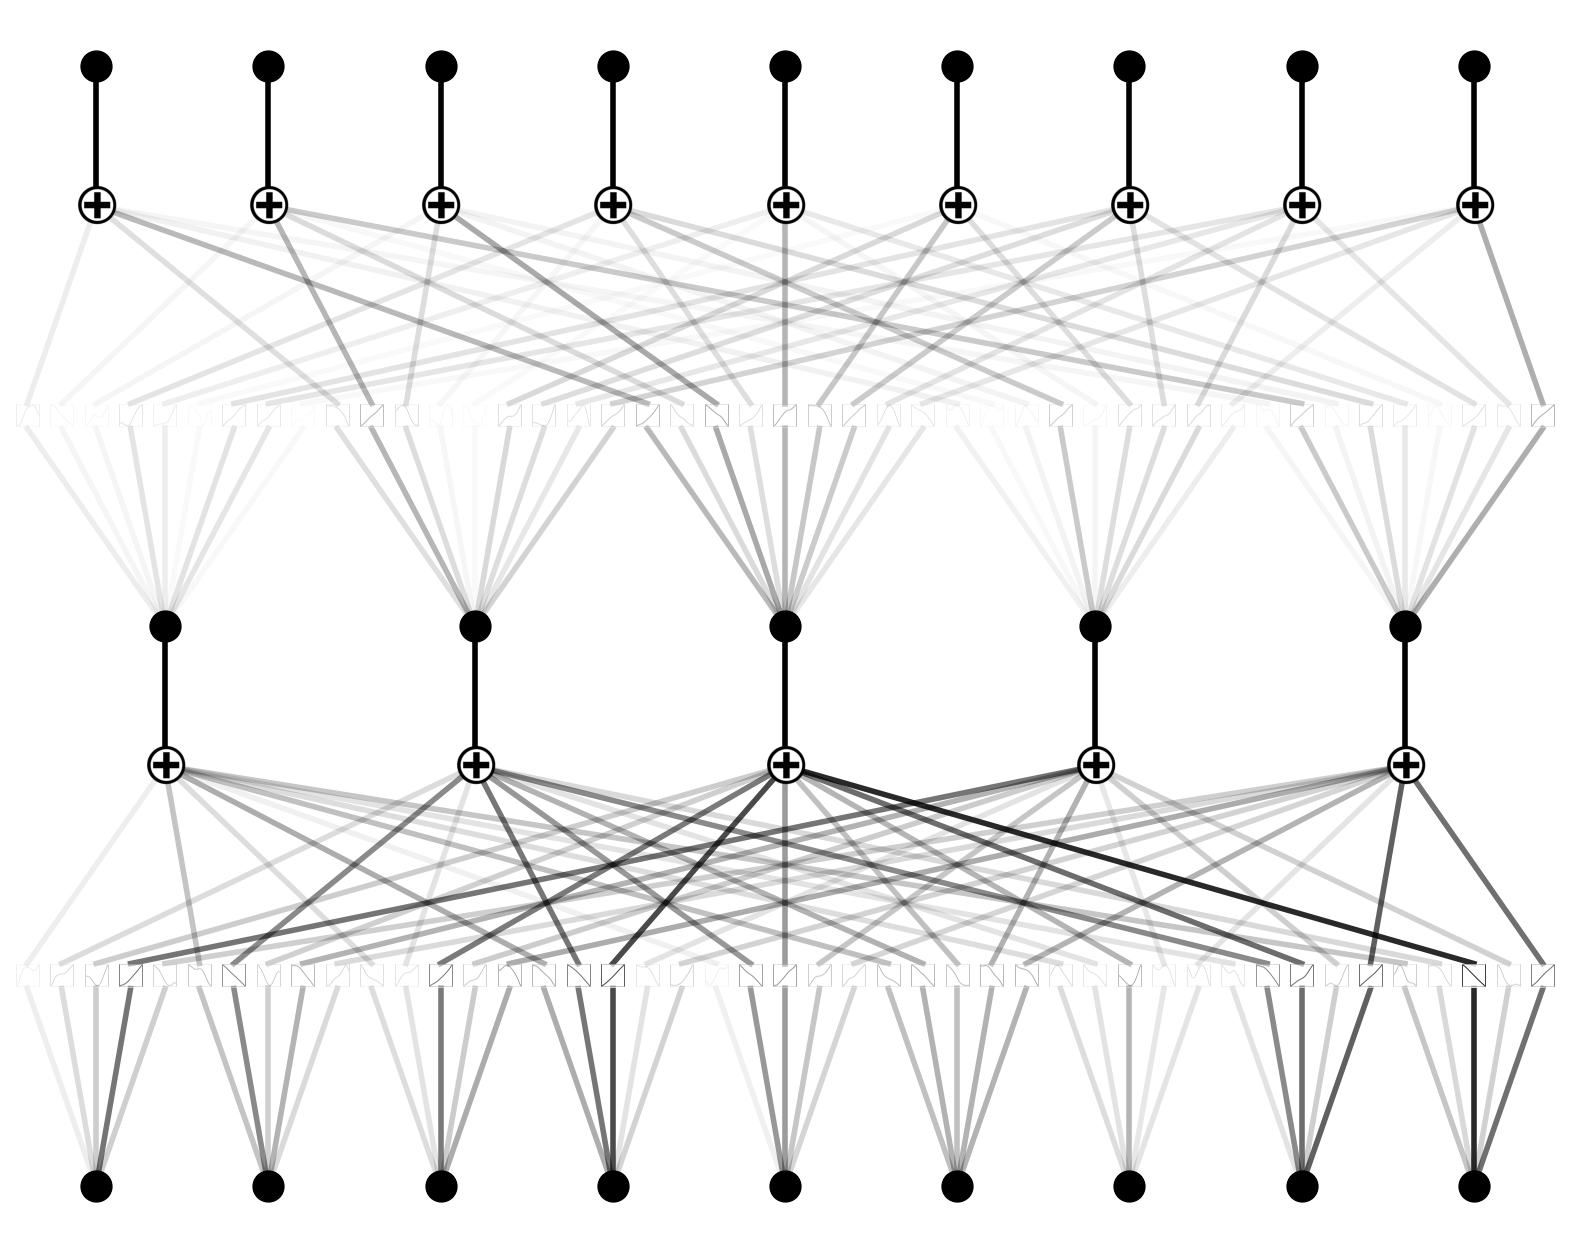

In [6]:
model.plot(scale=2)

In [7]:
model.prune(node_th=0.005, edge_th=0.015)

saving model version 0.1


MultKAN(
  (act_fun): ModuleList(
    (0-1): 2 x KANLayer(
      (base_fun): SiLU()
    )
  )
  (base_fun): SiLU()
  (symbolic_fun): ModuleList(
    (0-1): 2 x Symbolic_KANLayer()
  )
)

In [8]:
model.auto_symbolic()

fixing (0,0,0) with 0, r2=0.0, c=0
fixing (0,0,1) with 0, r2=0.0, c=0
fixing (0,0,2) with 0, r2=0.0, c=0
fixing (0,0,3) with sin, r2=0.9997256398200989, c=2
fixing (0,0,4) with sin, r2=0.9968819618225098, c=2
fixing (0,1,0) with 0, r2=0.0, c=0
fixing (0,1,1) with x, r2=0.9996283650398254, c=1
fixing (0,1,2) with 0, r2=0.0, c=0
fixing (0,1,3) with sin, r2=0.9991337656974792, c=2
fixing (0,1,4) with x, r2=0.9684339761734009, c=1
fixing (0,2,0) with 0, r2=0.0, c=0
fixing (0,2,1) with 0, r2=0.0, c=0
fixing (0,2,2) with x^2, r2=0.9996786117553711, c=2
fixing (0,2,3) with 0, r2=0.0, c=0
fixing (0,2,4) with sin, r2=0.9990493059158325, c=2
fixing (0,3,0) with x, r2=0.9869240522384644, c=1
fixing (0,3,1) with sin, r2=0.999992311000824, c=2
fixing (0,3,2) with sin, r2=0.9999624490737915, c=2
fixing (0,3,3) with 0, r2=0.0, c=0
fixing (0,3,4) with x^2, r2=0.9994485378265381, c=2
fixing (0,4,0) with 0, r2=0.0, c=0
fixing (0,4,1) with x, r2=0.99344402551651, c=1
fixing (0,4,2) with x, r2=0.995875120

In [9]:
sf = model.symbolic_formula()[0][0]
sf

-0.00604634471125415*exp(-0.837801222317228*x_2 - 0.691799999558436*x_5 - 0.503579098407412*x_6 - 0.177875539035626*x_7 + 1.16362692101445*sin(1.05223977565765*x_4 + 2.00519990921021) + 0.843243530261468*sin(1.2804799079895*x_8 + 1.78791987895966) + 0.303839481757631*cos(1.39975988864899*x_9 - 6.38751983642578)) + 0.0609563179314137*sin(0.222980242964392*x_5 + 0.344657935625535*x_8 - 0.637114034166604*x_9 + 0.130067818391093*(-x_3 - 0.685107423502027)**2 + 0.550215557709421*sin(0.968799829483032*x_4 + 5.39567995071411) - 0.0609006590504375*cos(2.90591979026794*x_6 + 3.66095972061157) - 0.745884291628242) + 0.074913770891726

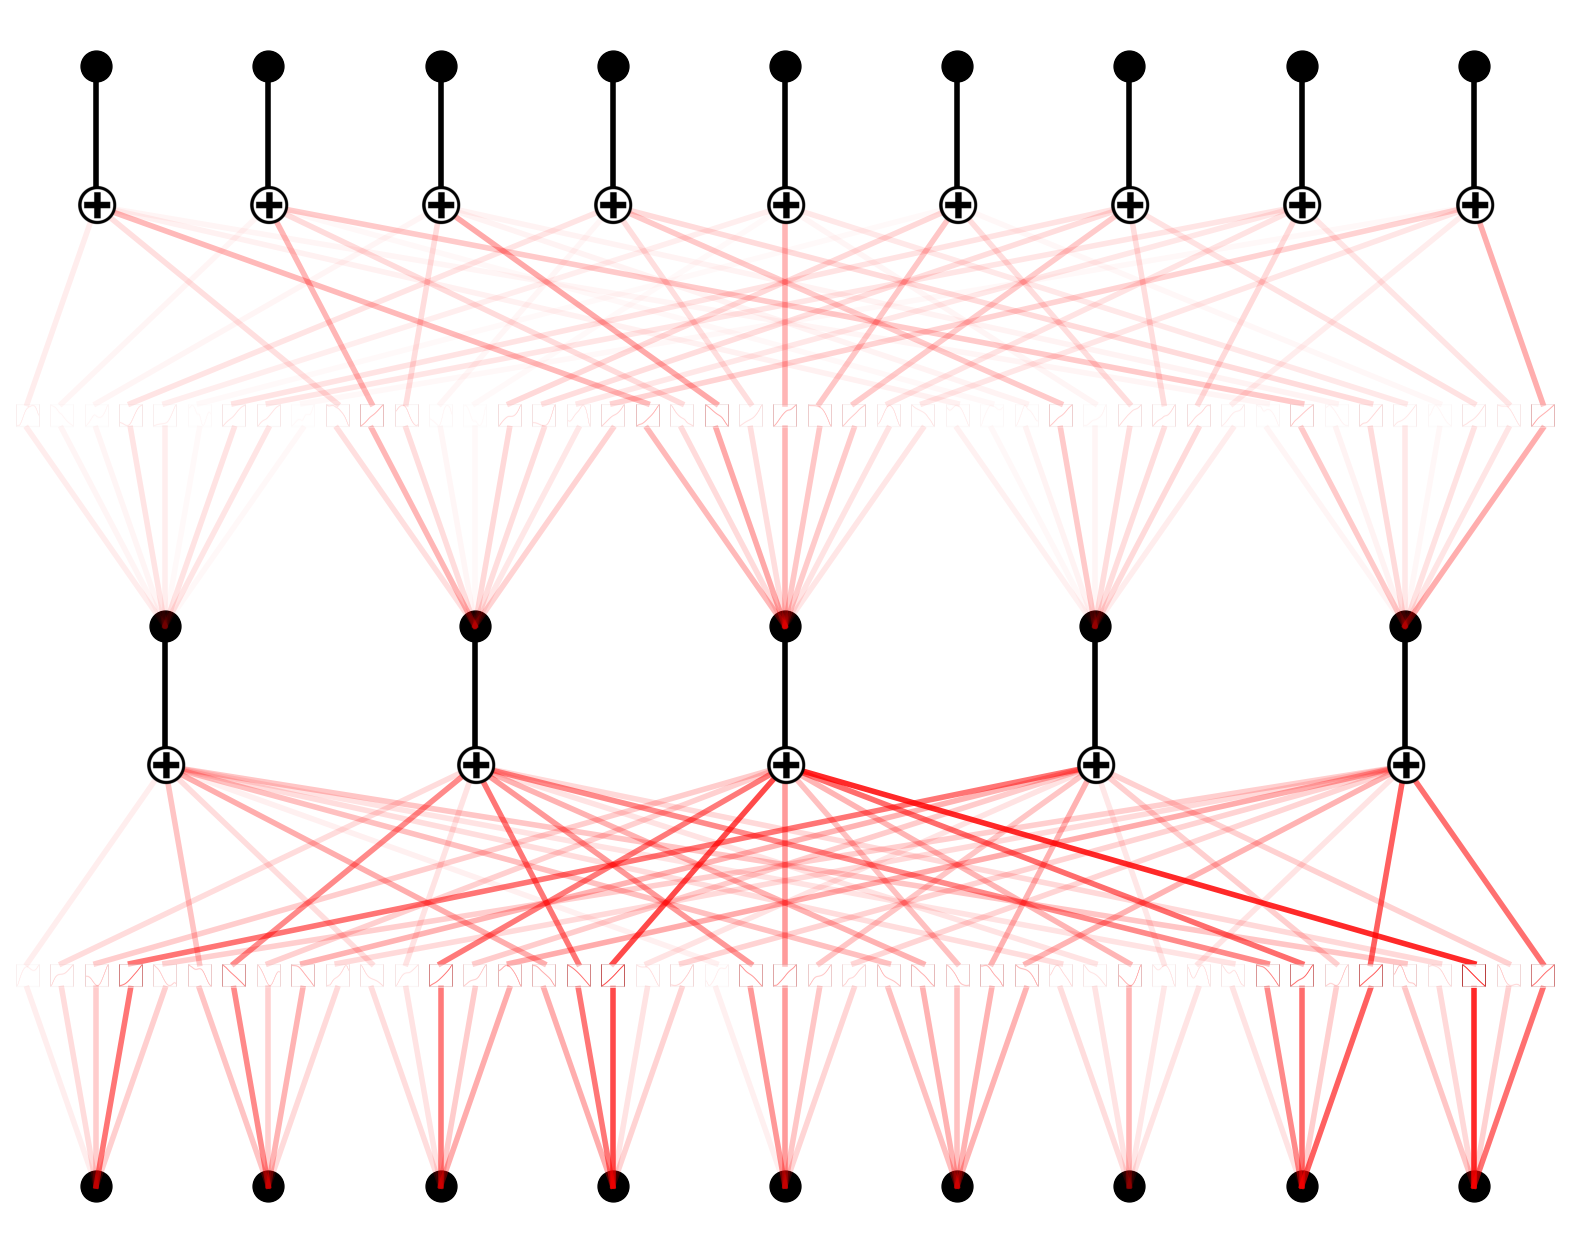

In [10]:
model.plot(scale=2)